This is a companion notebook for the book [Deep Learning with Python, Third Edition](https://www.manning.com/books/deep-learning-with-python-third-edition). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

The book's contents are available online at [deeplearningwithpython.io](https://deeplearningwithpython.io).

In [ ]:
!pip install keras keras-hub --upgrade -q

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [ ]:
# @title
import os
from IPython.core.magic import register_cell_magic

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

## Fundamentals of machine learning

이 장에서는 다음 내용을 다룹니다.

* 머신러닝의 근본적인 문제인 일반화와 최적화 사이의 긴장 관계 이해
* 머신러닝 모델 평가 방법
* 모델 적합도 향상을 위한 모범 사례
* 더 나은 일반화 성능 달성을 위한 모범 사례

4장의 세 가지 실습 예제를 통해 신경망을 사용하여 분류 및 회귀 문제를 해결하는 방법에 익숙해졌을 것이며, 머신러닝의 핵심 문제인 과적합에 대해서도 알게 되었을 것입니다. 이 장에서는 머신러닝에 대한 이러한 새로운 직관을 탄탄한 개념적 틀로 정리하고, 정확한 모델 평가의 중요성과 학습과 일반화 사이의 균형을 강조합니다.

### Generalization: The goal of machine learning

4장에서 제시된 세 가지 예제, 즉 영화 리뷰 예측, 주제 분류, 주택 가격 회귀 분석에서는 데이터를 훈련 세트, 검증 세트, 테스트 세트로 나누었습니다. 모델을 훈련에 사용한 데이터와 동일한 데이터로 평가하지 않아야 하는 이유는 금방 명확해졌습니다. 몇 에포크 만에 처음 보는 데이터에 대한 성능이 훈련 데이터에서의 성능과 차이를 보이기 시작했는데, 훈련 데이터에서의 성능은 훈련이 진행됨에 따라 항상 향상됩니다. 즉, 모델이 과적합되기 시작한 것입니다. 과적합은 모든 머신러닝 문제에서 발생합니다.

머신러닝의 근본적인 문제는 최적화와 일반화 사이의 균형입니다. 최적화는 훈련 데이터에서 최상의 성능을 얻도록 모델을 조정하는 과정(머신러닝에서의 학습)을 의미하는 반면, 일반화는 훈련된 모델이 처음 보는 데이터에 대해 얼마나 잘 작동하는지를 나타냅니다. 물론 목표는 좋은 일반화 성능을 얻는 것이지만, 일반화는 제어할 수 있는 것이 아닙니다. 모델을 훈련 데이터에 맞추는 것만 가능합니다. 만약 모델을 훈련 데이터에 너무 잘 맞추면 과적합이 발생하고 일반화 성능이 저하됩니다.

그렇다면 과적합의 원인은 무엇일까요? 어떻게 하면 좋은 일반화 성능을 얻을 수 있을까요?

#### Underfitting and overfitting

이전 장에서 살펴본 모든 모델의 경우, 검증 데이터셋에 대한 성능은 학습이 진행됨에 따라 처음에는 향상되다가 결국 일정 시간이 지나면서 정점에 도달했습니다. 그림 5.1에 나타낸 이 패턴은 보편적입니다. 어떤 모델 유형이나 어떤 데이터셋에서도 이러한 현상을 볼 수 있습니다.

<img src="https://deeplearningwithpython.io/images/ch05/typical_overfitting.8bd4c216.png" width="600"><p style="text-align:center">Figure 5.1: Canonical overfitting behavior</p>

학습 초기에는 최적화와 일반화가 상관관계가 있습니다. 학습 데이터에서의 손실이 낮을수록 테스트 데이터에서의 손실도 낮습니다. 이러한 상태일 때 모델은 과소적합 상태라고 합니다. 즉, 아직 개선의 여지가 있으며, 네트워크가 학습 데이터의 모든 관련 패턴을 아직 학습하지 못한 상태입니다. 하지만 학습 데이터에 대한 반복 횟수가 일정 수준에 도달하면 일반화 성능 향상이 멈추고 검증 지표가 정체되다가 결국 저하되기 시작합니다. 이는 모델이 과적합되기 시작하는 시점입니다. 다시 말해, 모델은 학습 데이터에 특화된 패턴을 학습하기 시작하는데, 이러한 패턴은 새로운 데이터에는 잘못 적용되거나 관련성이 떨어지는 경우가 많습니다.

데이터에 노이즈가 많거나, 불확실성이 있거나, 희귀한 특징이 포함되어 있을 때 과적합이 발생할 가능성이 특히 높습니다. 구체적인 예를 살펴보겠습니다.보겠습니다.

##### Noisy training data

실제 데이터셋에서는 입력값이 유효하지 않은 경우가 꽤 흔합니다. 예를 들어, MNIST 숫자 데이터셋에 완전히 검은색 이미지가 있을 수도 있고, 그림 5.2와 같은 경우도 있습니다.

<img src="https://deeplearningwithpython.io/images/ch05/weird_mnist.84598aa0.png" width="600"><p style="text-align:center">Figure 5.2: Some pretty weird MNIST training samples</p>

이것들은 무엇일까요? 저희도 알 수 없습니다. 하지만 모두 MNIST 학습 데이터셋의 일부입니다. 더 심각한 문제는 그림 5.3처럼 완벽하게 유효한 입력값이 잘못 분류되는 경우입니다.

<img src="https://deeplearningwithpython.io/images/ch05/mislabeled_mnist.e7a71e65.png" width="600"><p style="text-align:center">Figure 5.3: Mislabeled MNIST training samples</p>

모델이 이러한 이상치를 의도적으로 포함시키려고 하면 그림 5.4에서처럼 일반화 성능이 저하됩니다. 예를 들어, 그림 5.3에서 잘못 분류된 4와 매우 유사한 4가 9로 분류될 수 있습니다.

<img src="https://deeplearningwithpython.io/images/ch05/outliers_and_overfitting.919c6421.png" width="600"><p style="text-align:center">Figure 5.4: Dealing with outliers: robust fit vs. overfitting</p>

##### Ambiguous features

모든 데이터 노이즈가 부정확성에서 비롯되는 것은 아닙니다. 완벽하게 깨끗하고 레이블이 잘 지정된 데이터조차도 불확실성과 모호성이 있는 문제에서는 노이즈가 발생할 수 있습니다(그림 5.5 참조). 분류 작업에서는 입력 특징 공간의 일부 영역이 동시에 여러 클래스와 연관되는 경우가 종종 있습니다. 예를 들어 바나나 이미지를 입력받아 바나나가 익지 않았는지, 익었는지, 썩었는지 예측하는 모델을 개발한다고 가정해 보겠습니다. 이러한 범주에는 객관적인 경계가 없으므로 동일한 이미지라도 사람에 따라 익지 않았거나 익었다고 분류될 수 있습니다. 마찬가지로 많은 문제에는 무작위성이 포함됩니다. 대기압 데이터를 사용하여 내일 비가 올지 예측할 수 있지만, 동일한 측정값이 때로는 비가 오고 때로는 맑은 하늘이 될 수 있으며, 이러한 확률적 변화가 발생할 수 있습니다.

<img src="https://deeplearningwithpython.io/images/ch05/overfitting_with_uncertainty.7eace2a5.png" width="600"><p style="text-align:center">Figure 5.5: Robust fit vs. overfitting giving an ambiguous area of the feature space</p>
 
모델은 그림 5.6에서처럼 특징 공간의 모호한 영역에 대해 지나치게 확신함으로써 이러한 확률적 데이터에 과적합될 수 있습니다. 보다 견고한 적합을 위해서는 개별 데이터 포인트를 무시하고 전체적인 그림을 살펴보아야 합니다.

##### Rare features and spurious correlations

만약 당신이 평생 동안 주황색 얼룩무늬 고양이를 두 마리밖에 보지 못했고, 그 두 마리 모두 극도로 비사교적이었다면, 주황색 얼룩무늬 고양이는 일반적으로 비사교적일 가능성이 높다고 추론할 수도 있습니다. 이는 과적합(overfitting)입니다. 만약 당신이 더 다양한 고양이, 특히 주황색 고양이를 더 많이 접했다면, 고양이의 털 색깔과 성격 사이에는 밀접한 상관관계가 없다는 것을 알게 되었을 것입니다.

마찬가지로, 드문 특징 값을 포함하는 데이터셋으로 학습된 머신러닝 모델은 과적합에 매우 취약합니다. 감정 분류 작업에서, "체리모야"(안데스 산맥 원산의 과일)라는 단어가 학습 데이터셋의 텍스트 중 단 한 개에만 나타나고, 그 텍스트의 감정이 부정적이라면, 정규화가 제대로 되지 않은 모델은 이 단어에 매우 높은 가중치를 부여하여 체리모야를 언급하는 새로운 텍스트들을 모두 부정적으로 분류할 수 있습니다. 하지만 객관적으로 볼 때 체리모야 자체에는 부정적인 요소가 전혀 없습니다. [1]

중요한 것은, 특징 값이 단 두 번만 나타나는 것이 아니더라도 잘못된 상관관계를 유발할 수 있다는 점입니다. 훈련 데이터에서 100개의 샘플에 나타나는 단어를 생각해 보세요. 이 단어는 54%의 확률로 긍정적인 감정과 연관되고 46%의 확률로 부정적인 감정과 연관됩니다. 이러한 차이는 단순히 통계적 우연일 수도 있지만, 모델은 분류 작업에 이 특징을 사용하도록 학습할 가능성이 높습니다. 이것이 과적합의 가장 흔한 원인 중 하나입니다.

놀라운 예를 들어 보겠습니다. MNIST 데이터셋을 생각해 보세요. 기존 784차원 데이터에 784차원의 백색 잡음을 추가하여 새로운 훈련 데이터셋을 생성합니다. 즉, 데이터의 절반이 잡음이 되는 것입니다. 비교를 위해 784차원의 모든 요소가 0인 데이터셋도 생성해 보겠습니다. 이렇게 의미 없는 특징을 추가해도 데이터의 정보량에는 전혀 영향을 미치지 않습니다. 단지 관련 없는 데이터 포인트만 추가될 뿐입니다. 따라서 인간의 분류 정확도는 이러한 변환에 전혀 영향을 받지 않습니다.

In [11]:
from keras.datasets import mnist
import numpy as np

(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

train_images_with_noise_channels = np.concatenate(
    [train_images, np.random.random((len(train_images), 784))], axis=1
)

train_images_with_zeros_channels = np.concatenate(
    [train_images, np.zeros((len(train_images), 784))], axis=1
)

자, 이제 2장에서 만든 모델을 이 두 가지 훈련 데이터셋을 사용하여 학습시켜 보겠습니다.

In [14]:
import keras
from keras import layers

def get_model():
    model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(10, activation="softmax"),
        ]
    )
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

model = get_model()
history_noise = model.fit(
    train_images_with_noise_channels,
    train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
)

model = get_model()
history_zeros = model.fit(
    train_images_with_zeros_channels,
    train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7813 - loss: 0.7232 - val_accuracy: 0.9084 - val_loss: 0.3080
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9268 - loss: 0.2474 - val_accuracy: 0.9451 - val_loss: 0.1941
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9515 - loss: 0.1655 - val_accuracy: 0.9523 - val_loss: 0.1640
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9680 - loss: 0.1092 - val_accuracy: 0.9495 - val_loss: 0.1728
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9752 - loss: 0.0855 - val_accuracy: 0.9523 - val_loss: 0.1592
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9825 - loss: 0.0610 - val_accuracy: 0.9590 - val_loss: 0.1444
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9903 - loss: 0.0378 - val_accuracy: 0.9613 - val_loss: 0.1394
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9942 - loss: 0.0265 - val_accuracy: 0.

두 경우 모두 동일한 정보를 담고 있는 데이터임에도 불구하고, 노이즈 채널로 학습된 모델의 검증 정확도는 허위 상관관계의 영향으로 약 1%포인트 낮아집니다(그림 5.6). 노이즈 채널이 많아질수록 정확도는 더욱 떨어집니다.

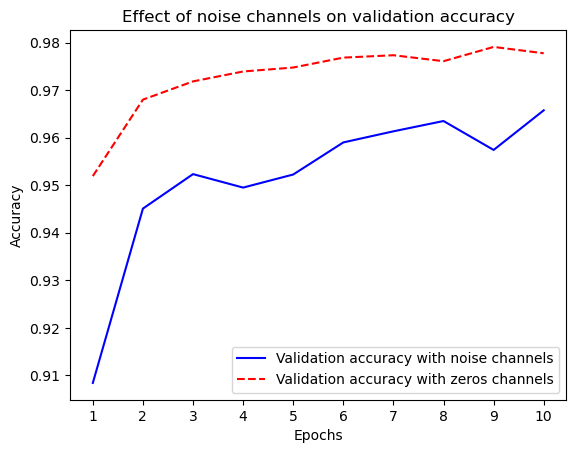

In [17]:
import matplotlib.pyplot as plt

val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_zeros.history["val_accuracy"]
epochs = range(1, 11)
plt.plot(
    epochs,
    val_acc_noise,
    "b-",
    label="Validation accuracy with noise channels",
)
plt.plot(
    epochs,
    val_acc_zeros,
    "r--",
    label="Validation accuracy with zeros channels",
)
plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

잡음이 섞인 특징은 필연적으로 과적합을 초래합니다. 따라서 보유한 특징이 유용한지 아니면 오히려 방해가 되는지 확신할 수 없는 경우에는 학습 전에 특징 선택을 하는 것이 일반적입니다. 예를 들어, IMDB 데이터에서 가장 많이 사용되는 단어 10,000개로 제한하는 것은 특징 선택의 한 형태입니다. 일반적인 특징 선택 방법은 각 특징에 대해 유용성 점수를 계산하는 것입니다. 이 점수는 특징과 레이블 간의 상호 정보량과 같이 해당 특징이 작업에 얼마나 유용한지를 나타내는 척도입니다. 그리고 특정 임계값보다 높은 특징만 유지합니다. 이렇게 하면 앞의 예에서 백색 잡음 채널을 걸러낼 수 있습니다.

#### The nature of generalization in deep learning

딥러닝 모델의 놀라운 점 중 하나는 충분한 표현력만 있다면 어떤 데이터셋에도 적응하도록 학습시킬 수 있다는 것입니다.

믿기지 않으시나요? MNIST 데이터셋의 레이블 순서를 뒤섞고 모델을 학습시켜 보세요. 입력값과 뒤섞인 레이블 사이에는 아무런 연관성이 없음에도 불구하고, 비교적 작은 모델에서도 학습 손실은 상당히 감소합니다. 물론, 이러한 상황에서는 일반화가 불가능하기 때문에 검증 손실은 시간이 지나도 전혀 개선되지 않습니다.

In [20]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

random_train_labels = train_labels[:]
np.random.shuffle(random_train_labels)

model = keras.Sequential(
    [
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_images,
    random_train_labels,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
)

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1012 - loss: 2.3297 - val_accuracy: 0.1019 - val_loss: 2.3051
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1205 - loss: 2.2974 - val_accuracy: 0.1029 - val_loss: 2.3121
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1265 - loss: 2.2886 - val_accuracy: 0.1034 - val_loss: 2.3204
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1389 - loss: 2.2760 - val_accuracy: 0.1021 - val_loss: 2.3241
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1567 - loss: 2.2604 - val_accuracy: 0.0976 - val_loss: 2.3306
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1696 - loss: 2.2404 - val_accuracy: 0.1011 - val_loss: 2.3449
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1871 - loss: 2.2137 - val_accuracy: 0.0993 - val_loss: 2.3614
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1993 - loss: 2.1896 - val_accu

사실 MNIST 데이터의 경우 이런 과정조차 필요 없습니다. 그냥 백색 잡음 입력과 무작위 레이블을 생성해도 됩니다. 충분한 매개변수만 있다면 이런 데이터에도 모델을 학습시킬 수 있습니다. 그러면 모델은 마치 파이썬 딕셔너리처럼 특정 입력값만 암기하게 될 것입니다.

그렇다면 딥러닝 모델은 왜 일반화 능력을 갖는 걸까요? 마치 고급 딕셔너리처럼 훈련 입력값과 목표값 사이의 임의적인 매핑을 학습하면 되지 않을까요? 이런 매핑이 새로운 입력값에도 제대로 작동할 거라고 어떻게 기대할 수 있을까요?

알고 보니 딥러닝에서 일반화의 본질은 딥러닝 모델 자체보다는 현실 세계의 정보 구조와 훨씬 더 관련이 깊습니다. 이제 그 실체를 자세히 살펴보겠습니다.

##### The manifold hypothesis


전처리 전 MNIST 분류기의 입력은 0에서 255 사이의 정수로 이루어진 28 × 28 배열입니다. 따라서 가능한 입력값의 총 개수는 256의 784제곱으로, 우주에 있는 원자의 개수보다 훨씬 많습니다. 하지만 이 입력값 중 유효한 MNIST 샘플처럼 보이는 것은 극히 드뭅니다. 실제 손글씨 숫자는 가능한 모든 28 × 28 uint8 배열로 이루어진 전체 공간에서 극히 작은 부분 공간만을 차지합니다. 더욱이, 이 부분 공간은 전체 공간에 무작위로 흩어져 있는 점들의 집합이 아니라, 매우 구조화된 공간입니다.

첫째, 유효한 손글씨 숫자로 이루어진 부분 공간은 연속적입니다. 샘플을 가져와 약간 수정하더라도 여전히 같은 손글씨 숫자로 인식될 수 있습니다. 또한, 유효한 부분 공간 내의 모든 샘플은 부분 공간을 관통하는 매끄러운 경로로 연결되어 있습니다. 즉, 임의의 MNIST 숫자 A와 B를 선택하면, A가 B로 변형되는 일련의 "중간" 이미지가 존재하여 연속된 두 숫자가 매우 유사하게 나타납니다(그림 5.7 참조). 두 클래스의 경계 부근에는 다소 모호한 모양이 있을 수 있지만, 이러한 모양조차도 여전히 숫자처럼 보일 것입니다.

<img src="https://deeplearningwithpython.io/images/ch05/mnist_manifold.665acfb1.png" width="600"><p style="text-align:center">Figure 5.7: Different MNIST digits gradually morphing into one another, showing that the space of handwritten digits forms a “manifold.” This image was generated using code from chapter 17.</p>

전문 용어로 설명하자면, 손글씨 숫자는 가능한 28 × 28 uint8 배열 공간 내에서 매니폴드를 형성한다고 할 수 있습니다. 다소 어려운 용어이지만, 개념은 직관적입니다. 매니폴드는 어떤 상위 공간의 저차원 부분 공간으로, 국소적으로 선형(유클리드) 공간과 유사합니다. 예를 들어, 평면상의 매끄러운 곡선은 2차원 공간 내의 1차원 매니폴드입니다. 곡선의 모든 점에서 접선을 그릴 수 있기 때문입니다(곡선은 모든 점에서 직선으로 근사화될 수 있습니다). 3차원 공간 내의 매끄러운 표면도 2차원 매니폴드입니다. 이와 같은 방식으로 계속됩니다.

더 일반적으로, 매니폴드 가설은 모든 자연 데이터가 인코딩된 고차원 공간 내의 저차원 매니폴드 상에 존재한다고 주장합니다. 이는 우주 정보 구조에 대한 매우 강력한 주장입니다. 우리가 아는 한, 이 가설은 정확하며 딥러닝이 작동하는 이유이기도 합니다. MNIST 숫자 데이터뿐만 아니라 사람 얼굴, 나무 형태, 사람 목소리, 심지어 자연어에도 적용됩니다.

매니폴드 가설은 다음과 같은 의미를 내포합니다.

* 머신러닝 모델은 잠재적 입력 공간(잠재 매니폴드) 내에서 상대적으로 단순하고 저차원이며 고도로 구조화된 부분 공간에만 맞추면 됩니다.

* 이러한 매니폴드 중 하나 내에서는 항상 두 입력 사이를 보간할 수 있습니다. 즉, 모든 점이 매니폴드 상에 놓이는 연속적인 경로를 통해 한 입력을 다른 입력으로 변형할 수 있습니다.

샘플 간 보간 능력은 딥러닝에서 일반화를 이해하는 데 핵심입니다.

##### Interpolation as a source of generalization

보간 가능한 데이터 포인트를 사용하면, 이전에 본 적 없는 포인트들을 매니폴드 상의 가까운 다른 포인트들과 연관시켜 의미를 파악할 수 있습니다. 다시 말해, 공간의 일부만을 사용하여 공간 전체를 이해할 수 있는 것입니다. 보간을 통해 빈 공간을 채울 수 있는 것이죠.

그림 5.8에서 볼 수 있듯이, 잠재 매니폴드 상에서의 보간은 부모 공간에서의 선형 보간과 다릅니다. 예를 들어, MNIST 데이터셋의 두 숫자 사이의 픽셀 평균은 일반적으로 유효한 숫자가 아닙니다.

<img src="https://deeplearningwithpython.io/images/ch05/linear_interpolation_vs_manifold_interpolation.75960718.png" width="600"><p style="text-align:center">Figure 5.8: Difference between linear interpolation and interpolation on the latent manifold. Every point on the latent manifold of digits is a valid digit, but the average of two digits usually isn’t.</p>

그림 5.8: 선형 보간과 잠재 매니폴드 상에서의 보간의 차이. 잠재 매니폴드 상의 모든 포인트는 유효한 숫자이지만, 두 숫자의 평균은 일반적으로 유효하지 않습니다.
중요한 것은, 딥러닝이 데이터 매니폴드의 학습된 근사치를 기반으로 보간을 통해 일반화를 달성하지만, 보간이 일반화의 전부라고 생각하는 것은 잘못이라는 점입니다. 이것은 빙산의 일각에 불과합니다. 보간법은 이전에 본 것과 매우 유사한 것들을 이해하는 데 도움을 줄 뿐입니다. 즉, 국소적인 일반화를 가능하게 합니다. 하지만 놀랍게도 인간은 극도로 새로운 상황에 끊임없이 대처하며 잘 해냅니다. 앞으로 마주하게 될 모든 상황에 대한 수많은 예시를 미리 학습할 필요는 없습니다. 우리의 하루하루는 이전에 경험했던 어떤 날과도 다르고, 인류의 태동기 이후 그 누구도 경험했던 어떤 날과도 다릅니다. 뉴욕, 상하이, 방갈로르에서 일주일을 보내는 것을 번갈아 가며 할 때, 각 도시에 대해 수천 번의 삶을 투자하여 학습하고 연습할 필요가 없습니다.

인간은 극단적인 일반화 능력을 가지고 있는데, 이는 보간법 외에도 추상화, 세계에 대한 상징적 모델, 추론, 논리, 상식, 세상에 대한 선천적인 사전 지식 등 다양한 인지 메커니즘, 즉 우리가 일반적으로 직관이나 패턴 인식과 대비되는 '이성'이라고 부르는 것들을 통해 가능해집니다. 후자는 본질적으로 보간적이지만 전자는 그렇지 않습니다. 이 두 가지 모두 지능에 필수적입니다. 이 내용은 19장에서 더 자세히 다루겠습니다.

##### Why deep learning works

2장에서 언급했던 구겨진 종이 공 비유를 기억하시나요? 종이 한 장은 3차원 공간 내의 2차원 매니폴드를 나타냅니다(그림 5.9). 딥러닝 모델은 구겨진 종이 공을 펴는 도구, 즉 잠재된 매니폴드를 풀어내는 도구입니다.

<img src="https://deeplearningwithpython.io/images/ch02/geometric_interpretation_4.f8123b83.png" width="600"><p style="text-align:center">Figure 5.9: Uncrumpling a complicated manifold of data</p>

딥러닝 모델은 기본적으로 매우 고차원적인 곡선입니다. 이 곡선은 미분 가능해야 하므로 매끄럽고 연속적입니다(모델 아키텍처 사전 정보에서 비롯된 구조적 제약 조건은 추가됨). 그리고 이 곡선은 경사 하강법을 통해 데이터 포인트에 맞춰 부드럽고 점진적으로 조정됩니다. 딥러닝은 본질적으로 크고 복잡한 곡선, 즉 매니폴드를 가져와서 훈련 데이터 포인트에 맞을 때까지 매개변수를 점진적으로 조정하는 것입니다.

이 곡선은 매우 많은 매개변수를 포함하므로 어떤 데이터에도 맞을 수 있습니다. 실제로 모델을 충분히 오랫동안 훈련시키면 훈련 데이터만 암기하게 되어 일반화 능력이 전혀 없어질 수 있습니다. 하지만 여러분이 학습시키려는 데이터는 기본 공간에 드문드문 분포된 고립된 점들로 이루어진 것이 아닙니다. 데이터는 입력 공간 내에서 고도로 구조화된 저차원 매니폴드를 형성합니다. 이것이 바로 매니폴드 가설입니다. 경사 하강법을 통해 모델 곡선을 데이터에 맞추는 과정은 시간이 지남에 따라 점진적이고 부드럽게 진행되므로, 그림 5.10에서 볼 수 있듯이 학습 과정 중 모델이 데이터의 자연스러운 매니폴드에 대략적으로 근접하는 중간 지점이 존재합니다.

<img src="https://deeplearningwithpython.io/images/ch05/the_cartoon_of_fitting.096e7b07.png" width="600"><p style="text-align:center">Figure 5.10: Going from a random model to an overfit model and achieving a robust fit as an intermediate state</p>

이 시점에서 모델이 학습한 곡선을 따라 이동하면 데이터의 실제 잠재 매니폴드를 따라 이동하는 것과 매우 유사해집니다. 따라서 모델은 훈련 입력값 사이의 보간을 통해 이전에 본 적 없는 입력값도 이해할 수 있게 됩니다.

심층 학습 모델은 충분한 표현력을 갖추고 있다는 자명한 사실 외에도, 잠재 매니폴드를 학습하는 데 특히 적합한 몇 가지 특성을 지니고 있습니다.

* 심층 학습 모델은 입력에서 출력으로의 매끄럽고 연속적인 매핑을 구현합니다. 이 매핑은 미분 가능해야 하므로(그렇지 않으면 경사 하강법을 사용할 수 없기 때문에) 매끄럽고 연속적이어야 합니다. 이러한 매끄러움은 동일한 속성을 따르는 잠재 매니폴드를 근사하는 데 도움이 됩니다.
* 심층 학습 모델은 아키텍처 사전 정보를 통해 훈련 데이터의 정보 "형태"를 반영하는 방식으로 구조화되는 경향이 있습니다. 이는 특히 이미지 처리 모델(8~12장 참조)과 시퀀스 처리 모델(13장 참조)에서 두드러지게 나타납니다. 더 일반적으로, 심층 신경망은 자연 데이터의 구성 방식과 유사하게 계층적이고 모듈화된 방식으로 학습된 표현을 구조화합니다.

##### Training data is paramount

딥러닝은 매니폴드 학습에 매우 적합하지만, 일반화 능력은 모델의 속성보다는 데이터의 자연스러운 구조에 더 크게 좌우됩니다. 데이터가 점들을 보간할 수 있는 매니폴드를 형성해야만 일반화가 가능합니다. 특징이 더 유익하고 노이즈가 적을수록 입력 공간이 더 단순하고 잘 구조화되므로 일반화 능력이 향상됩니다. 데이터 큐레이션과 특징 엔지니어링은 일반화에 필수적입니다.

또한, 딥러닝은 곡선 맞춤이기 때문에 모델의 성능을 높이려면 입력 공간을 촘촘하게 샘플링하여 학습해야 합니다. 여기서 "촘촘한 샘플링"이란 학습 데이터가 입력 데이터 매니폴드 전체를 촘촘하게 커버해야 함을 의미합니다(그림 5.11 참조). 특히 결정 경계 부근에서 이러한 특성이 두드러집니다. 충분히 조밀한 샘플링을 통해, 상식이나 추상적 추론, 또는 외부 세계에 대한 지식 없이도 과거 훈련 입력값 사이를 보간하여 새로운 입력값을 이해할 수 있게 됩니다. 이는 머신러닝 모델이 접근할 수 없는 모든 요소들을 활용하는 것입니다.

<img src="https://deeplearningwithpython.io/images/ch05/dense_sampling.c8a0767c.png" width="600"><p style="text-align:center">Figure 5.11: A dense sampling of the input space is necessary to learn a model capable of accurate generalization.</p>

따라서 딥러닝 모델의 성능을 향상시키는 가장 좋은 방법은 더 많은 데이터 또는 더 나은 데이터로 학습시키는 것임을 항상 명심해야 합니다(물론, 지나치게 잡음이 많거나 부정확한 데이터를 추가하면 일반화 성능이 저하됩니다). 입력 데이터 매니폴드를 더 조밀하게 커버할수록 일반화 성능이 더 뛰어난 모델을 얻을 수 있습니다. 딥러닝 모델은 훈련 샘플 간의 단순한 보간 이상의 성능을 기대해서는 안 되며, 따라서 보간을 최대한 쉽게 수행할 수 있도록 모든 노력을 기울여야 합니다. 딥러닝 모델에서 발견할 수 있는 유일한 것은 바로 여러분이 입력한 데이터, 즉 아키텍처에 인코딩된 사전 정보와 학습에 사용된 데이터입니다.

더 많은 데이터를 확보할 수 없을 때, 차선책은 모델이 저장할 수 있는 정보의 양을 조절하거나 모델 곡선의 평활도에 제약을 두는 것입니다. 네트워크가 소수의 패턴이나 매우 규칙적인 패턴만 기억할 수 있다면, 최적화 과정은 모델이 일반화 성능이 더 좋을 가능성이 높은 가장 두드러진 패턴에 집중하도록 만듭니다. 이러한 방식으로 과적합을 방지하는 과정을 정규화라고 합니다. 정규화 기법에 대해서는 5.4.4절에서 자세히 살펴보겠습니다.

모델의 일반화 성능을 향상시키기 위해 모델을 조정하기 전에, 모델의 현재 성능을 평가하는 방법이 필요합니다. 다음 절에서는 모델 개발 과정에서 일반화 성능을 모니터링하는 방법인 모델 평가에 대해 알아보겠습니다.

### Evaluating machine-learning models

관찰할 수 있는 것만 제어할 수 있습니다. 여러분의 목표는 새로운 데이터에 성공적으로 일반화할 수 있는 모델을 개발하는 것이므로, 모델의 일반화 능력을 신뢰할 수 있게 측정하는 것이 필수적입니다. 이 섹션에서는 머신러닝 모델을 평가하는 다양한 방법을 공식적으로 소개합니다. 대부분의 방법은 이전 장에서 이미 살펴보았습니다.

#### Training, validation, and test sets

모델 평가는 항상 사용 가능한 데이터를 세 가지 세트, 즉 훈련, 검증 및 테스트 세트로 나누는 것으로 요약됩니다. 훈련 데이터로 모델을 학습시키고 검증 데이터로 모델을 평가합니다. 모델이 실제 운영 환경에 배포할 준비가 되면, 실제 운영 데이터와 최대한 유사한 테스트 데이터로 최종 테스트를 진행합니다. 그런 다음 모델을 실제 운영 환경에 배포할 수 있습니다.

혹시 훈련 세트와 테스트 세트, 이렇게 두 개의 데이터 세트를 사용하면 되지 않느냐고 질문할 수도 있습니다. 훈련 데이터로 학습시키고 테스트 데이터로 평가하면 훨씬 간단하지 않겠냐는 것입니다.

그 이유는 모델 개발에는 항상 모델 설정을 조정하는 과정이 포함되기 때문입니다. 예를 들어, 레이어 개수나 레이어 크기(네트워크 가중치인 파라미터와 구분하기 위해 하이퍼파라미터라고 함)를 선택하는 것입니다. 이러한 조정은 검증 데이터에서 얻은 모델 성능을 피드백 신호로 사용하여 수행합니다. 본질적으로 이 조정은 일종의 학습, 즉 파라미터 공간에서 최적의 설정을 찾는 과정입니다. 결과적으로, 검증 세트에서의 성능을 기반으로 모델 설정을 조정하면, 모델이 검증 세트로 직접 학습되지 않았음에도 불구하고 검증 세트에 과적합되는 현상이 빠르게 발생할 수 있습니다.

이 현상의 핵심에는 정보 유출이라는 개념이 있습니다. 검증 세트에서의 모델 성능을 기반으로 하이퍼파라미터를 조정할 때마다 검증 데이터에 대한 일부 정보가 모델로 유출됩니다. 만약 한 번만, 하나의 파라미터에 대해서만 이러한 작업을 수행한다면 유출되는 정보의 양은 매우 적어 검증 세트는 모델 평가에 여전히 신뢰할 수 있는 자료로 남을 것입니다. 하지만 이러한 과정을 여러 번 반복한다면, 즉 한 번의 실험을 수행하고 검증 세트에서 평가한 후 모델을 수정하는 과정을 반복한다면, 검증 세트에 대한 정보가 점점 더 많이 모델로 유출될 것입니다.

결국, 모델은 검증 데이터에 최적화되었기 때문에 검증 데이터에서 인위적으로 좋은 성능을 보이게 될 것입니다. 검증 데이터가 아닌 완전히 새로운 데이터셋에서의 성능이 중요하므로, 모델 평가에는 이전에 본 적 없는 완전히 다른 데이터셋, 즉 테스트 데이터셋을 사용해야 합니다. 모델은 테스트 데이터셋에 대한 어떠한 정보에도 접근해서는 안 됩니다. 직간접적으로라도 말이죠. 만약 모델이 테스트 데이터셋 성능을 기반으로 튜닝되었다면, 일반화 성능 측정에 오류가 발생할 수 있습니다.

데이터를 훈련, 검증, 테스트 데이터셋으로 분할하는 것은 간단해 보이지만, 데이터가 부족할 때 유용한 몇 가지 고급 방법이 있습니다. 세 가지 고전적인 평가 방법인 단순 홀드아웃 검증, K-겹 교차 검증, 그리고 셔플링을 사용한 반복 K-겹 교차 검증을 살펴보겠습니다. 또한, 훈련이 제대로 진행되고 있는지 확인하기 위한 일반적인 기준선 사용법에 대해서도 이야기해 보겠습니다.

##### Simple hold-out validation

전체 데이터의 일부를 테스트 세트로 따로 분리합니다. 나머지 데이터로 모델을 학습시키고, 테스트 세트에서 성능을 평가합니다. 앞서 살펴본 것처럼 정보 유출을 방지하기 위해 테스트 세트를 기반으로 모델을 튜닝해서는 안 되므로, 검증 세트도 따로 마련해야 합니다.

홀드아웃 검증의 개략적인 구성은 그림 5.12와 같습니다. 다음은 간단한 구현 예시입니다.

<img src="https://deeplearningwithpython.io/images/ch05/holdout_validation.55d20cbc.png" width="400"><p style="text-align:center">Figure 5.12: Simple hold-out validation split</p>

In [ ]:
num_validation_samples = 10000
# Shuffling the data is usually appropriate.
np.random.shuffle(data)
# Defines the validation set
validation_data = data[:num_validation_samples]
# Defines the training set
training_data = data[num_validation_samples:]
# Trains a model on the training data and evaluates it on the
# validation data
model = get_model()
model.fit(training_data, ...)
validation_score = model.evaluate(validation_data, ...)

# At this point, you can tune your model, retrain it, evaluate it, tune
# it again, and so on.
...

# Once you've tuned your hyperparameters, it's common to train your
# final model from scratch on all non-test data available.
model = get_model()
model.fit(
    np.concatenate([training_data, validation_data]),
    ...,
)
test_score = model.evaluate(test_data, ...)

이는 가장 간단한 평가 프로토콜이지만, 한 가지 단점이 있습니다. 데이터가 부족한 경우, 검증 및 테스트 세트에 포함된 샘플 수가 전체 데이터를 통계적으로 대표하기에 충분하지 않을 수 있습니다. 이는 쉽게 확인할 수 있습니다. 데이터를 분할하기 전에 무작위로 섞는 과정을 여러 번 반복했을 때 모델 성능 측정값이 크게 다르게 나온다면, 바로 이 문제입니다. 다음에서 설명할 K-겹 교차 검증과 반복 K-겹 교차 검증은 이러한 문제를 해결하는 두 가지 방법입니다.

##### K-fold validation

이 접근 방식에서는 데이터를 동일한 크기의 K개 파티션으로 나눕니다. 각 파티션 i에 대해 나머지 K-1개 파티션에서 모델을 학습시키고, 파티션 i에서 모델을 평가합니다. 최종 점수는 이렇게 얻은 K개 점수의 평균입니다. 이 방법은 모델 성능이 학습/테스트 분할에 따라 상당한 편차를 보일 때 유용합니다. 홀드아웃 검증과 마찬가지로, 이 방법 또한 모델 보정을 위해 별도의 검증 세트를 사용해야 합니다.

K-겹 교차 검증의 개략도는 그림 5.13과 같습니다. 간단한 구현 예는 목록 5.6에 나와 있습니다.

<img src="https://deeplearningwithpython.io/images/ch05/k_fold_validation.1fd60660.png" width="600"><p style="text-align:center">Figure 5.13: Three-fold validation</p>

In [ ]:
k = 3
num_validation_samples = len(data) // k
np.random.shuffle(data)
validation_scores = []
for fold in range(k):
    # Selects the validation-data partition
    validation_data = data[
        num_validation_samples * fold : num_validation_samples * (fold + 1)
    ]
    # Uses the remainder of the data as training data.
    training_data = np.concatenate(
        data[: num_validation_samples * fold],
        data[num_validation_samples * (fold + 1) :],
    )
    # Creates a brand-new instance of the model (untrained)
    model = get_model()
    model.fit(training_data, ...)
    validation_score = model.evaluate(validation_data, ...)
    validation_scores.append(validation_score)
# Validation score: average of the validation scores of the k folds
validation_score = np.average(validation_scores)
# Trains the final model on all non-test data available
model = get_model()
model.fit(data, ...)
test_score = model.evaluate(test_data, ...)

##### Iterated K-fold validation with shuffling

이 방법은 사용 가능한 데이터가 상대적으로 적고 모델을 최대한 정확하게 평가해야 하는 상황에 적합합니다. 저는 Kaggle 대회에서 이 방법이 매우 유용하다는 것을 알게 되었습니다. 이 방법은 K-겹 교차 검증을 여러 번 적용하고, 매번 데이터를 섞은 후 K개로 분할하는 방식으로 구성됩니다. 최종 점수는 각 K-겹 교차 검증 실행에서 얻은 점수의 평균입니다. 이 방법을 사용하면 P * K개의 모델(P는 반복 횟수)을 학습하고 평가하게 되므로 비용이 상당히 많이 들 수 있다는 점에 유의해야 합니다.

#### Beating a common-sense baseline

다양한 평가 프로토콜 외에도 알아두면 좋은 마지막 한 가지는 상식적인 기준선(baseline)의 활용입니다.

딥러닝 모델을 훈련하는 것은 마치 평행 세계에서 로켓을 발사하는 버튼을 누르는 것과 같습니다. 소리도 들리지 않고, 모습도 볼 수 없습니다. 수많은 차원의 학습 과정을 관찰할 수도 없습니다. 수천 개의 차원으로 이루어진 공간에서 일어나고 있기 때문에 3D로 투영한다고 해도 해석할 수 없습니다. 유일한 피드백은 검증 지표뿐입니다. 마치 보이지 않는 로켓의 고도계와 같습니다.

특히 중요한 점은 제대로 이륙하고 있는지 여부를 파악하는 것입니다. 처음 시작했을 때의 고도는 얼마였을까요? 모델의 정확도가 15%라면, 좋은 결과일까요? 데이터셋을 사용하기 전에 항상 넘어서야 할 간단한 기준선을 선택해야 합니다. 이 기준선을 넘어서면 모델이 입력 데이터의 정보를 활용하여 일반화 가능한 예측을 하고 있다는 뜻이므로, 계속 진행할 수 있습니다. 이 기준선은 무작위 분류기의 성능일 수도 있고, 여러분이 상상할 수 있는 가장 간단한 비머신러닝 기법의 성능일 수도 있습니다.

예를 들어, MNIST 숫자 분류 예제에서 간단한 기준선은 0.1보다 큰 검증 정확도(무작위 분류기)가 될 수 있습니다. IMDB 예제에서는 0.5보다 큰 검증 정확도가 기준선이 될 수 있습니다. 로이터 예제에서는 클래스 불균형 때문에 0.18~0.19 정도가 될 것입니다. 만약 90%의 샘플이 A 클래스에 속하고 10%가 B 클래스에 속하는 이진 분류 문제에서 항상 A를 예측하는 분류기는 이미 0.9의 검증 정확도를 달성하지만, 여러분은 그보다 더 나은 성능을 내야 합니다.

아무도 해결하지 못한 문제를 처음 시작할 때는 참고할 수 있는 상식적인 기준선을 갖는 것이 매우 중요합니다. 간단한 해결책조차 이길 수 없다면, 당신의 모델은 쓸모가 없습니다. 어쩌면 잘못된 모델을 사용하고 있거나, 애초에 머신러닝으로 해결할 수 없는 문제일지도 모릅니다. 처음부터 다시 시작해야 할 때입니다.

#### Things to keep in mind about model evaluation

평가 프로토콜을 선택할 때 다음 사항에 유의하세요.

* 데이터 대표성 — 훈련 세트와 테스트 세트 모두 실제 데이터를 대표해야 합니다. 예를 들어, 숫자 이미지를 분류하는 경우, 클래스별로 정렬된 샘플 배열에서 시작하여 배열의 80%를 훈련 세트로, 나머지 20%를 테스트 세트로 사용하면 훈련 세트에는 클래스 0~7만 포함되고 테스트 세트에는 클래스 8~9만 포함되게 됩니다. 이는 어처구니없는 실수처럼 보이지만, 의외로 흔히 발생합니다. 따라서 일반적으로 데이터를 훈련 세트와 테스트 세트로 분할하기 전에 무작위로 섞는 것이 좋습니다.

* 시간의 흐름 — 과거 데이터를 기반으로 미래를 예측하려는 경우(예: 내일 날씨, 주가 변동 등), 데이터를 분할하기 전에 무작위로 섞으면 시간적 누출이 발생하여 모델이 사실상 미래의 데이터로 학습되는 결과를 초래할 수 있으므로 주의해야 합니다. 이러한 상황에서는 테스트 세트의 모든 데이터가 훈련 세트의 데이터보다 나중에 생성되었는지 항상 확인해야 합니다.

* 데이터 중복 — 데이터에서 일부 데이터 포인트가 두 번 나타나는 경우(실제 데이터에서는 상당히 흔한 일입니다), 데이터를 섞고 훈련 세트와 검증 세트로 나누면 훈련 세트와 검증 세트 사이에 중복이 발생합니다. 사실상 훈련 데이터의 일부로 테스트하는 셈인데, 이는 최악의 상황입니다! 훈련 세트와 검증 세트가 서로 겹치지 않도록 하세요.

모델 성능을 평가하는 신뢰할 수 있는 방법을 갖추는 것은 머신 러닝의 핵심인 최적화와 일반화, 과소적합과 과대적합 사이의 균형을 유지하는 데 도움이 됩니다.

### Improving model fit

완벽한 적합을 달성하려면 먼저 과적합(overfitting)을 해야 합니다. 경계가 어디에 있는지 미리 알 수 없기 때문에, 경계를 넘어서야만 최적의 모델을 찾을 수 있습니다. 따라서 문제를 풀기 시작할 때의 초기 목표는 어느 정도 일반화 능력을 보여주고 과적합될 수 있는 모델을 만드는 것입니다. 이러한 모델을 만든 후에는 과적합을 방지하면서 일반화 능력을 개선하는 데 집중하게 됩니다.

이 단계에서 흔히 발생하는 세 가지 문제는 다음과 같습니다.

* 학습이 시작되지 않음: 학습 손실이 시간이 지나도 줄어들지 않음.

* 학습은 정상적으로 시작되지만, 모델의 일반화 능력이 미흡함: 설정한 상식적인 기준선(baseline)을 넘어서지 못함.

* 학습 손실과 검증 손실 모두 시간이 지남에 따라 감소하고 기준선보다 나은 성능을 보이지만, 과적합이 발생하지 않아 여전히 과소적합 상태임.

머신러닝 프로젝트의 첫 번째 주요 목표인 일반화 능력(단순한 기준선을 능가하는 성능)과 과적합 능력을 갖춘 모델을 구축하기 위해 이러한 문제들을 어떻게 해결할 수 있는지 살펴보겠습니다.

#### Tuning key gradient descent parameters

때때로 학습이 시작되지 않거나 너무 일찍 멈추는 경우가 있습니다. 손실 함수가 고정되는 것이죠. 하지만 이는 항상 해결할 수 있는 문제입니다. 임의의 데이터로도 모델을 학습시킬 수 있다는 사실을 기억하세요. 문제가 전혀 말이 안 되더라도, 학습 데이터를 암기하는 것만으로도 모델을 학습시킬 수는 있습니다.

이런 상황이 발생할 때는 항상 경사 하강법 과정의 설정 문제입니다. 옵티마이저 선택, 모델 가중치의 초기값 분포, 학습률, 배치 크기 등이 원인일 수 있습니다. 이러한 매개변수들은 서로 연관되어 있으므로, 보통 나머지 매개변수는 고정하고 학습률과 배치 크기만 조정하면 문제를 해결할 수 있습니다.

구체적인 예를 들어 보겠습니다. 2장에서 다룬 MNIST 모델을 학습률 1이라는 부적절하게 큰 값으로 학습시켜 보겠습니다.

In [55]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

model = keras.Sequential(
    [
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1.0),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_images, train_labels, epochs=10, batch_size=128, validation_split=0.2
)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4431 - loss: 4807.7559 - val_accuracy: 0.2152 - val_loss: 2.2809
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2338 - loss: 2.6649 - val_accuracy: 0.2504 - val_loss: 2.4782
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2420 - loss: 2.7708 - val_accuracy: 0.2110 - val_loss: 2.2337
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2025 - loss: 2.5514 - val_accuracy: 0.2251 - val_loss: 2.1578
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2111 - loss: 2.3554 - val_accuracy: 0.1739 - val_loss: 2.1897
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2113 - loss: 2.3937 - val_accuracy: 0.2326 - val_loss: 2.2832
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2203 - loss: 2.4771 - val_accuracy: 0.1986 - val_loss: 2.1771
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2141 - loss: 2.3423 - val_accuracy:

모델은 학습 및 검증 정확도에서 20%~40% 범위에 빠르게 도달하지만, 그 이상으로는 올라가지 못합니다. 학습률을 1e-2라는 보다 적절한 값으로 낮춰 보겠습니다.

In [57]:
model = keras.Sequential(
    [
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-2),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_images, train_labels, epochs=10, batch_size=128, validation_split=0.2
)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8257 - loss: 0.9332 - val_accuracy: 0.9586 - val_loss: 0.1438
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9633 - loss: 0.1283 - val_accuracy: 0.9603 - val_loss: 0.1630
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9741 - loss: 0.0962 - val_accuracy: 0.9680 - val_loss: 0.1448
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9797 - loss: 0.0780 - val_accuracy: 0.9697 - val_loss: 0.1542
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9834 - loss: 0.0634 - val_accuracy: 0.9733 - val_loss: 0.1592
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9854 - loss: 0.0613 - val_accuracy: 0.9729 - val_loss: 0.1734
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9885 - loss: 0.0492 - val_accuracy: 0.9741 - val_loss: 0.1797
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9884 - loss: 0.0499 - val_accuracy: 0.

이제 모델 학습이 가능합니다.

비슷한 상황에 처했을 때는 다음 방법을 시도해 보세요.

* 학습률을 낮추거나 높여 보세요. 학습률이 너무 높으면 이전 예시처럼 적절한 적합 범위를 크게 벗어나는 업데이트가 발생할 수 있고, 학습률이 너무 낮으면 학습 속도가 너무 느려져 학습이 멈춘 것처럼 보일 수 있습니다.

* 배치 크기를 늘려 보세요. 배치에 더 많은 샘플을 포함하면 더 유익하고 노이즈가 적은(분산이 낮은) 기울기를 얻을 수 있습니다.

결국에는 학습이 시작될 수 있는 최적의 설정을 찾을 수 있을 것입니다.

#### Using better architecture priors

모델은 잘 만들어졌지만, 어떤 이유에서인지 검증 지표가 전혀 개선되지 않고 있습니다. 마치 무작위 분류기처럼 결과가 나오지 않는 거죠. 모델은 학습은 잘 되지만 일반화 능력이 부족한 겁니다. 도대체 무슨 문제일까요?

이런 상황은 머신러닝에서 가장 최악의 경우일 수 있습니다. 접근 방식에 근본적인 문제가 있다는 뜻인데, 원인을 파악하기가 쉽지 않을 수 있습니다. 몇 가지 힌트를 드리겠습니다.

첫째, 사용 중인 입력 데이터에 목표값을 예측하기에 충분한 정보가 없는 것일 수 있습니다. 즉, 문제 자체가 해결 불가능한 상황일 수 있습니다. 앞서 레이블이 섞인 MNIST 데이터셋으로 모델을 학습시켰을 때와 같은 상황입니다. 모델은 학습은 잘 되지만, 검증 정확도가 10%에 머물렀던 이유는 이러한 데이터셋으로는 일반화가 불가능했기 때문입니다.

둘째, 사용 중인 모델 유형이 당면한 문제에 적합하지 않은 것일 수도 있습니다. 예를 들어, 13장에서는 밀집 연결 아키텍처가 단순한 기준선조차 넘어서지 못하는 시계열 예측 문제의 예시를 볼 수 있습니다. 반면, 더 적합한 순환 아키텍처는 일반화 성능이 우수합니다. 일반화 성능을 달성하려면 문제에 대한 올바른 가정을 하는 모델을 사용하는 것이 필수적입니다. 즉, 적절한 아키텍처 사전 정보를 활용해야 합니다.

다음 장에서는 이미지, 텍스트, 시계열 등 다양한 데이터 유형에 적합한 최적의 아키텍처에 대해 배우게 됩니다. 일반적으로, 자신이 해결하려는 문제에 대한 아키텍처 모범 사례를 항상 숙지해야 합니다. 왜냐하면 여러분이 시도하는 문제가 이미 다른 사람들에 의해 제기되었을 가능성이 높기 때문입니다.

#### Increasing model capacity

검증 지표가 감소하고 어느 정도 일반화 능력을 갖춘 것처럼 보이는 적합한 모델을 만들었다면 축하합니다. 거의 다 왔습니다. 다음 단계는 모델이 과적합되도록 만드는 것입니다.

다음은 MNIST 픽셀 데이터셋으로 학습된 간단한 로지스틱 회귀 모델입니다.

In [61]:
model = keras.Sequential([layers.Dense(10, activation="softmax")])
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history_small_model = model.fit(
    train_images, train_labels, epochs=20, batch_size=128, validation_split=0.2
)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7366 - loss: 1.0357 - val_accuracy: 0.9042 - val_loss: 0.3624
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9004 - loss: 0.3653 - val_accuracy: 0.9130 - val_loss: 0.3107
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9080 - loss: 0.3244 - val_accuracy: 0.9174 - val_loss: 0.2938
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9147 - loss: 0.3066 - val_accuracy: 0.9220 - val_loss: 0.2837
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9180 - loss: 0.2907 - val_accuracy: 0.9228 - val_loss: 0.2786
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9212 - loss: 0.2845 - val_accuracy: 0.9237 - val_loss: 0.2746
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9216 - loss: 0.2825 - val_accuracy: 0.9243 - val_loss: 0.2734
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9232 - loss: 0.2693 - val_accuracy: 0.

손실 곡선은 그림 5.14와 같은 형태를 나타냅니다.

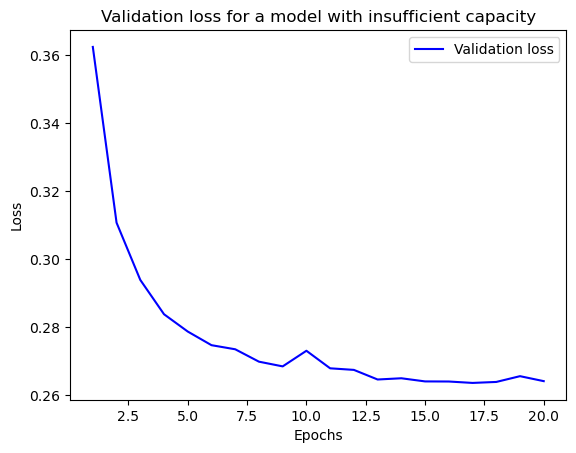

In [63]:
import matplotlib.pyplot as plt

val_loss = history_small_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b-", label="Validation loss")
plt.title("Figure 5.14: Validation loss for a model with insufficient capacity")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

검증 지표가 정점을 찍고 반등하는 대신 정체되거나 매우 느리게 개선되는 것처럼 보입니다. 검증 손실이 0.26에 도달한 후 그대로 유지됩니다. 학습에는 성공하지만, 훈련 데이터에 대해 여러 번 반복 학습을 해도 과적합이 명확하게 나타나지 않습니다. 앞으로 비슷한 상황을 자주 접하게 될 것입니다.

과적합은 항상 가능하다는 점을 기억하세요. "학습 손실이 감소하지 않는" 문제와 마찬가지로, 이 문제도 항상 해결할 수 있습니다. 과적합이 어려운 경우, 모델의 표현력에 문제가 있을 가능성이 높습니다. 더 많은 정보를 저장할 수 있는 더 큰 모델, 즉 더 많은 용량을 가진 모델이 필요합니다. 표현력은 레이어를 추가하거나, 더 큰 레이어(더 많은 매개변수를 가진 레이어)를 사용하거나, 문제에 더 적합한 레이어 유형(더 나은 아키텍처 사전 정보)을 사용하여 향상시킬 수 있습니다.

이제 각각 128개의 유닛을 가진 두 개의 중간 레이어를 포함하는 더 큰 모델을 학습시켜 보겠습니다.

In [65]:
model = keras.Sequential(
    [
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history_large_model = model.fit(
    train_images,
    train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8369 - loss: 0.5817 - val_accuracy: 0.9529 - val_loss: 0.1621
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9537 - loss: 0.1507 - val_accuracy: 0.9635 - val_loss: 0.1213
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9719 - loss: 0.0977 - val_accuracy: 0.9691 - val_loss: 0.1001
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9782 - loss: 0.0686 - val_accuracy: 0.9715 - val_loss: 0.0950
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9833 - loss: 0.0552 - val_accuracy: 0.9758 - val_loss: 0.0872
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9876 - loss: 0.0423 - val_accuracy: 0.9742 - val_loss: 0.0954
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9881 - loss: 0.0355 - val_accuracy: 0.9753 - val_loss: 0.0941
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9906 - loss: 0.0294 - val_accuracy: 0.

이제 학습 곡선은 예상대로 나타납니다. 모델은 빠르게 학습되고 8 에포크 후에 과적합되기 시작합니다(그림 5.15 참조).

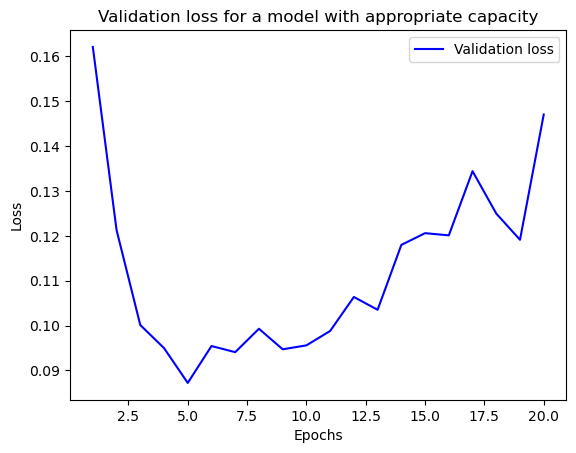

In [67]:
val_loss = history_large_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b-", label="Validation loss")
plt.title("Figure 5.15: Validation loss for a model with appropriate capacity")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

문제를 해결하기 위해 과도하게 매개변수화된 모델을 사용하는 것이 일반적이지만, 기억 용량이 너무 크면 문제가 될 수 있다는 점에 유의하십시오. 모델이 너무 크면 바로 과적합이 발생합니다. 다음은 각 레이어에 2,048개의 유닛이 있는 3개의 중간 레이어를 가진 MNIST 모델의 경우입니다(그림 5.16 참조).

In [69]:
model = keras.Sequential(
    [
        layers.Dense(2048, activation="relu"),
        layers.Dense(2048, activation="relu"),
        layers.Dense(2048, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history_very_large_model = model.fit(
    train_images,
    train_labels,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
)

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 115s 76ms/step - accuracy: 0.8688 - loss: 0.4385 - val_accuracy: 0.9588 - val_loss: 0.1657
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 115s 77ms/step - accuracy: 0.9686 - loss: 0.1176 - val_accuracy: 0.9729 - val_loss: 0.1266
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 114s 76ms/step - accuracy: 0.9787 - loss: 0.0842 - val_accuracy: 0.9713 - val_loss: 0.1318
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 116s 77ms/step - accuracy: 0.9841 - loss: 0.0650 - val_accuracy: 0.9728 - val_loss: 0.1447
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 118s 79ms/step - accuracy: 0.9875 - loss: 0.0552 - val_accuracy: 0.9768 - val_loss: 0.1256
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 114s 76ms/step - accuracy: 0.9892 - loss: 0.0423 - val_accuracy: 0.9781 - val_loss: 0.1535
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 114s 76ms/step - accuracy: 0.9921 - loss: 0.0312 - val_accuracy: 0.9782 - val_loss: 0.1798
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 114s 76ms/step - accuracy: 

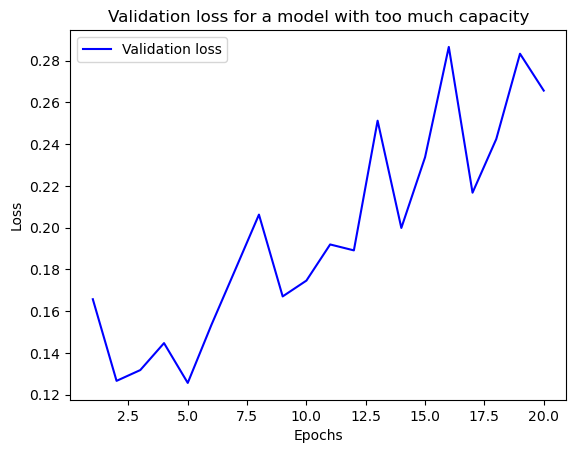

In [70]:
val_loss = history_very_large_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b-", label="Validation loss")
plt.title("Figure 5.16: Validation loss for a model with too much capacity")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Improving generalization

모델이 어느 정도 일반화 능력을 보여주고 과적합될 수 있다는 것이 입증되면, 이제 일반화 능력을 극대화하는 데 초점을 맞춰야 할 때입니다.

#### Dataset curation

딥러닝에서 일반화는 데이터의 잠재 구조에서 비롯된다는 것을 이미 배웠습니다. 데이터가 샘플 간의 매끄러운 보간을 가능하게 한다면, 일반화 능력이 뛰어난 딥러닝 모델을 학습시킬 수 있습니다. 하지만 리스트 정렬처럼 문제가 지나치게 노이즈가 많거나 근본적으로 이산적인 경우에는 딥러닝이 도움이 되지 않습니다. 딥러닝은 곡선 맞춤이지 마법이 아닙니다.

따라서 적절한 데이터셋을 사용하는 것이 매우 중요합니다. 더 나은 모델을 개발하는 데 드는 비용과 노력을 고려하는 것보다 데이터 수집에 더 많은 노력과 비용을 투자하는 것이 훨씬 더 큰 투자 수익을 가져다주는 경우가 많습니다.

* 충분한 데이터를 확보하세요. 입력-출력 공간을 촘촘하게 샘플링해야 한다는 점을 기억하세요. 데이터가 많을수록 더 나은 모델을 만들 수 있습니다. 때로는 처음에는 불가능해 보였던 문제도 더 큰 데이터셋을 통해 해결할 수 있게 됩니다.
* 레이블링 오류를 최소화하세요. 입력값을 시각화하여 이상치를 확인하고 레이블을 꼼꼼히 검토하세요.
* 데이터를 정제하고 결측값을 처리하세요(다음 장에서 다룹니다).

* 특징이 너무 많아서 어떤 특징이 실제로 유용한지 확신이 서지 않는다면 특징 선택을 하세요.

특히 데이터의 일반화 가능성을 향상시키는 중요한 방법 중 하나는 특징 엔지니어링입니다. 대부분의 머신러닝 문제에서 특징 엔지니어링은 성공의 핵심 요소입니다. 자세히 살펴보겠습니다.

#### Feature engineering

특징 엔지니어링은 데이터와 사용 중인 머신러닝 알고리즘(이 경우 신경망)에 대한 지식을 활용하여, 모델에 입력하기 전에 데이터에 미리 정의된(학습되지 않은) 변환을 적용함으로써 알고리즘의 성능을 향상시키는 과정입니다. 많은 경우, 머신러닝 모델이 완전히 임의의 데이터로부터 학습할 수 있을 것이라고 기대하는 것은 비현실적입니다. 데이터는 모델의 작업을 용이하게 하는 방식으로 제공되어야 합니다.

직관적인 예를 살펴보겠습니다. 시계 이미지를 입력으로 받아 현재 시간을 출력하는 모델을 개발한다고 가정해 보겠습니다(그림 5.17 참조). 이미지의 원본 픽셀을 입력 데이터로 사용한다면, 매우 어려운 머신러닝 문제가 됩니다. 이 문제를 해결하려면 합성곱 신경망이 필요하며, 네트워크를 학습시키는 데 상당한 컴퓨팅 자원을 투입해야 합니다.

<img src="https://deeplearningwithpython.io/images/ch05/clock_diagram.3cbff177.png" width="500"><p style="text-align:center">Figure 5.17: Feature engineering for reading the time on a clock</p>

그림 5.17: 시계에서 시간을 읽기 위한 특징 엔지니어링
하지만 이미 문제를 높은 수준에서 이해하고 있다면(예: 사람이 시계에서 시간을 읽는 방식), 머신 러닝 알고리즘에 훨씬 더 나은 입력 특징을 만들어낼 수 있습니다. 예를 들어, 시계 바늘의 검은색 픽셀을 따라가 각 바늘 끝의 (x, y) 좌표를 출력하는 파이썬 스크립트를 다섯 줄로 작성하는 것은 간단합니다. 그러면 간단한 머신 러닝 알고리즘이 이러한 좌표를 해당 시간과 연결하는 방법을 학습할 수 있습니다.

더 나아가, 좌표 변환을 통해 (x, y) 좌표를 이미지 중심을 기준으로 하는 극좌표로 표현할 수도 있습니다. 그러면 입력값은 각 시계 바늘의 각도 세타가 됩니다. 이 시점에서는 특징 덕분에 문제가 매우 간단해져서 머신 러닝이 필요하지 않습니다. 간단한 반올림 연산과 사전 검색만으로도 대략적인 시간을 복구할 수 있습니다.

이것이 바로 특징 엔지니어링의 핵심입니다. 문제를 더 간단한 방식으로 표현함으로써 문제를 더 쉽게 만드는 것입니다. 잠재 매니폴드를 더 부드럽고, 단순하며, 체계적으로 만드세요. 이를 위해서는 보통 문제를 깊이 있게 이해해야 합니다.

딥러닝 이전에는 특징 엔지니어링이 머신러닝 워크플로에서 가장 중요한 부분이었습니다. 기존의 얕은 알고리즘들은 유용한 특징을 스스로 학습할 만큼 풍부한 가설 공간을 가지고 있지 않았기 때문입니다. 알고리즘에 데이터를 제공하는 방식이 알고리즘의 성공에 절대적으로 중요했습니다. 예를 들어, 합성곱 신경망이 MNIST 숫자 분류 문제에서 성공을 거두기 전에는 숫자 이미지의 루프 개수, 각 숫자의 높이, 픽셀 값의 히스토그램 등과 같은 하드코딩된 특징에 기반한 솔루션이 일반적이었습니다.

다행히도, 최신 딥러닝은 신경망이 원시 데이터에서 유용한 특징을 자동으로 추출할 수 있기 때문에 대부분의 특징 엔지니어링의 필요성을 없애줍니다. 그렇다면 딥 신경망을 사용하는 한 특징 엔지니어링에 대해 걱정할 필요가 없다는 뜻일까요? 아닙니다. 두 가지 이유가 있습니다.

* 좋은 특징은 여전히 ​​더 적은 리소스를 사용하면서도 문제를 더 효율적으로 해결할 수 있도록 해줍니다. 예를 들어, 합성곱 신경망을 사용하여 시계판을 읽는 문제를 해결하는 것은 터무니없는 일일 것입니다.
* 좋은 특징은 훨씬 적은 데이터로도 문제를 해결할 수 있게 해줍니다. 딥러닝 모델이 스스로 특징을 학습하는 능력은 풍부한 훈련 데이터에 의존합니다. 샘플이 몇 개밖에 없다면 특징에 담긴 정보의 가치가 매우 중요해집니다.

#### Using early stopping

딥러닝에서는 일반적으로 과도하게 매개변수화된 모델을 사용합니다. 즉, 데이터의 잠재 매니폴드에 적합하기 위해 필요한 최소한의 자유도보다 훨씬 많은 자유도를 갖습니다. 이러한 과도한 매개변수화는 문제가 되지 않는데, 딥러닝 모델은 결코 완전히 적합되는 법이 없기 때문입니다. 완전히 적합된 모델은 일반화 성능이 전혀 없습니다. 학습 손실이 최소가 되기 훨씬 전에 학습을 중단하게 됩니다.

학습 과정에서 가장 일반화 성능이 좋은 적합 지점, 즉 과소적합 곡선과 과대적합 곡선의 정확한 경계를 찾는 것이 일반화 성능을 향상시키는 가장 효과적인 방법 중 하나입니다.

이전 장의 예시에서는 최적의 검증 지표를 얻기 위해 필요한 에포크 수보다 훨씬 더 오랫동안 모델을 학습시킨 다음, 정확히 그 에포크 수만큼 새로운 모델을 재학습시켰습니다. 이는 매우 일반적인 방법입니다. 하지만 이 방법은 불필요한 작업을 반복하게 되므로 때로는 비용이 많이 들 수 있습니다. 물론, 각 에포크가 끝날 때마다 모델을 저장하고, 최적의 에포크를 찾은 후 저장된 모델 중 가장 유사한 모델을 재사용할 수도 있습니다. 케라스에서는 일반적으로 EarlyStopping 콜백을 사용하여 이를 구현합니다. 이 콜백은 검증 지표가 더 이상 개선되지 않으면 학습을 중단하고, 가장 좋은 모델 상태를 기억합니다. 콜백 사용법은 7장에서 자세히 다룹니다.

#### Regularizing your model

정규화 기법은 모델이 훈련 데이터에 완벽하게 적합되는 것을 적극적으로 방해하여 검증 단계에서 모델의 성능을 향상시키는 것을 목표로 하는 일련의 모범 사례입니다. 이러한 과정을 "정규화"라고 부르는 이유는 모델을 더 단순하고 "규칙적"으로 만들고, 성능 곡선을 더 부드럽게 하며, "일반화"하여 훈련 데이터셋에 대한 특이성을 줄이고 데이터의 잠재 매니폴드를 더 정확하게 근사화함으로써 일반화 능력을 향상시키기 때문입니다. 모델 "정규화"는 항상 정확한 평가 절차에 따라 진행되어야 한다는 점을 명심해야 합니다. 측정 가능한 일반화만이 진정한 일반화를 달성할 수 있습니다.

이제 가장 일반적인 정규화 기법 몇 가지를 살펴보고 4장에서 다룬 영화 분류 모델을 개선하는 데 실제로 적용해 보겠습니다.

##### Reducing the network's size

모델 크기가 너무 작으면 과적합이 발생하지 않는다는 것을 이미 배웠습니다. 과적합을 완화하는 가장 간단한 방법은 모델의 크기(모델의 학습 가능한 매개변수 개수, 레이어 수와 레이어당 유닛 수로 결정됨)를 줄이는 것입니다. 모델의 기억 자원이 제한적이면 훈련 데이터를 단순히 암기할 수 없습니다. 손실을 최소화하기 위해 모델은 목표 변수에 대한 예측력을 가진 압축된 표현을 학습해야 하는데, 바로 우리가 원하는 유형의 표현입니다. 동시에, 모델이 과소적합되지 않도록 충분한 매개변수를 가져야 한다는 점을 기억해야 합니다. 모델이 기억 자원이 부족해서는 안 됩니다. 너무 많은 용량과 너무 적은 용량 사이에는 균형점이 있습니다.

안타깝게도, 적절한 레이어 수나 각 레이어의 크기를 결정하는 마법 같은 공식은 없습니다. 데이터에 맞는 최적의 모델 크기를 찾으려면 다양한 아키텍처를 (물론 테스트 세트가 아닌 검증 세트에서) 평가해야 합니다. 적절한 모델 크기를 찾는 일반적인 워크플로는 비교적 적은 수의 레이어와 파라미터로 시작하여 검증 손실이 감소하는 지점까지 레이어 크기를 늘리거나 새로운 레이어를 추가하는 것입니다.

영화 리뷰 분류 모델에 이 방법을 적용해 보겠습니다. 다음은 4장에서 다룬 모델의 간략화된 버전입니다.

In [78]:
from keras.datasets import imdb

(train_data, train_labels), _ = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.0
    return results

train_data = vectorize_sequences(train_data)

model = keras.Sequential(
    [
        layers.Dense(16, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history_original = model.fit(
    train_data,
    train_labels,
    epochs=20,
    batch_size=512,
    validation_split=0.4,
)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6801 - loss: 0.6219 - val_accuracy: 0.8609 - val_loss: 0.4340
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8857 - loss: 0.3821 - val_accuracy: 0.8669 - val_loss: 0.3529
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9112 - loss: 0.2758 - val_accuracy: 0.8691 - val_loss: 0.3218
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9256 - loss: 0.2216 - val_accuracy: 0.8899 - val_loss: 0.2809
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9415 - loss: 0.1865 - val_accuracy: 0.8809 - val_loss: 0.2936
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9503 - loss: 0.1578 - val_accuracy: 0.8893 - val_loss: 0.2803
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9605 - loss: 0.1353 - val_accuracy: 0.8859 - val_loss: 0.2881
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9686 - loss: 0.1134 - val_accuracy: 0.8845 - v

이제 이 작은 모델로 교체해 보겠습니다.

In [80]:
model = keras.Sequential(
    [
        layers.Dense(4, activation="relu"),
        layers.Dense(4, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history_smaller_model = model.fit(
    train_data,
    train_labels,
    epochs=20,
    batch_size=512,
    validation_split=0.4,
)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6904 - loss: 0.6459 - val_accuracy: 0.8446 - val_loss: 0.5327
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8767 - loss: 0.4918 - val_accuracy: 0.8699 - val_loss: 0.4350
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8990 - loss: 0.3897 - val_accuracy: 0.8711 - val_loss: 0.3764
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9110 - loss: 0.3190 - val_accuracy: 0.8808 - val_loss: 0.3349
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9217 - loss: 0.2702 - val_accuracy: 0.8871 - val_loss: 0.3021
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9319 - loss: 0.2321 - val_accuracy: 0.8888 - val_loss: 0.2863
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9369 - loss: 0.2050 - val_accuracy: 0.8880 - val_loss: 0.2833
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9429 - loss: 0.1822 - val_accuracy: 0.8903 - v

그림 5.18은 원래 모델과 축소 모델의 검증 손실을 비교한 것입니다.

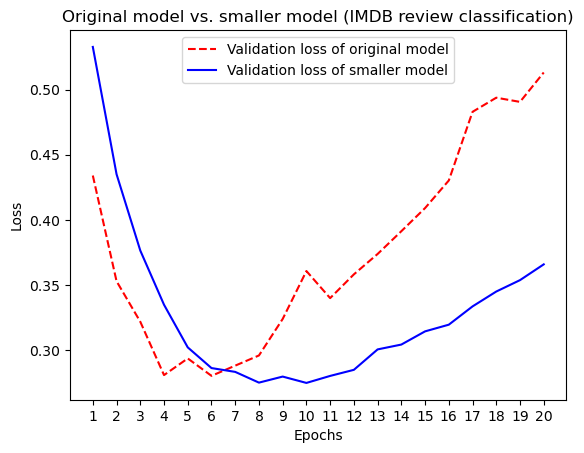

In [82]:
original_val_loss = history_original.history["val_loss"]
smaller_model_val_loss = history_smaller_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(
    epochs,
    original_val_loss,
    "r--",
    label="Validation loss of original model",
)
plt.plot(
    epochs,
    smaller_model_val_loss,
    "b-",
    label="Validation loss of smaller model",
)
plt.title("Original model vs. smaller model (IMDB review classification)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()
plt.show()

보시다시피, 더 작은 모델은 참조 모델보다 과적합이 더 늦게 시작됩니다(참조 모델은 4회 에포크 후, 참조 모델은 6회 에포크 후). 또한, 과적합이 시작된 후에도 성능 저하 속도가 더 느립니다.

이제, 문제의 필요 용량보다 훨씬 더 큰 모델을 벤치마크에 추가해 보겠습니다.

In [84]:
model = keras.Sequential(
    [
        layers.Dense(512, activation="relu"),
        layers.Dense(512, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history_larger_model = model.fit(
    train_data,
    train_labels,
    epochs=20,
    batch_size=512,
    validation_split=0.4,
)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.6195 - loss: 0.6387 - val_accuracy: 0.8649 - val_loss: 0.3541
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8686 - loss: 0.3374 - val_accuracy: 0.8356 - val_loss: 0.3783
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.8960 - loss: 0.2546 - val_accuracy: 0.8806 - val_loss: 0.2960
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9379 - loss: 0.1687 - val_accuracy: 0.8670 - val_loss: 0.3353
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9495 - loss: 0.1372 - val_accuracy: 0.8874 - val_loss: 0.2745
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9724 - loss: 0.0896 - val_accuracy: 0.8869 - val_loss: 0.3233
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9778 - loss: 0.0700 - val_accuracy: 0.8155 - val_loss: 0.6066
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9779 - loss: 0.0684 - val_accuracy: 0.8850 - v

그림 5.19는 더 큰 모델이 참조 모델에 비해 어떤 성능을 보이는지 보여줍니다. 더 큰 모델은 단 한 번의 에포크 만에 과적합되기 시작하며, 그 정도가 훨씬 심각합니다. 검증 손실 또한 더 불안정합니다. 훈련 손실은 매우 빠르게 0에 가까워집니다. 모델의 용량이 클수록 훈련 데이터를 더 빠르게 모델링할 수 있어 훈련 손실이 낮아지지만, 과적합에 더 취약해져 훈련 손실과 검증 손실 간의 차이가 커집니다.

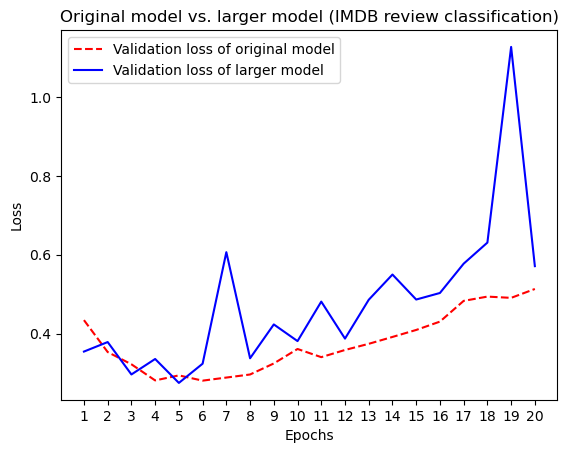

In [86]:
original_val_loss = history_original.history["val_loss"]
larger_model_val_loss = history_larger_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(
    epochs,
    original_val_loss,
    "r--",
    label="Validation loss of original model",
)
plt.plot(
    epochs,
    larger_model_val_loss,
    "b-",
    label="Validation loss of larger model",
)
plt.title("Original model vs. larger model (IMDB review classification)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()
plt.show()

##### Adding weight regularization

오컴의 면도날 원리에 대해 들어보셨을 겁니다. 어떤 현상에 대해 두 가지 설명이 있다면, 가장 단순한 설명, 즉 가정이 적은 설명이 옳을 가능성이 가장 높다는 것입니다. 이 원리는 신경망이 학습하는 모델에도 적용됩니다. 주어진 훈련 데이터와 네트워크 아키텍처를 고려할 때, 여러 가지 가중치 값(여러 모델)이 데이터를 설명할 수 있습니다. 단순한 모델은 복잡한 모델보다 과적합될 가능성이 적습니다.

여기서 단순한 모델이란 매개변수 값 분포의 엔트로피가 낮은 모델(또는 이전 섹션에서 살펴본 것처럼 매개변수 개수가 적은 모델)을 의미합니다. 따라서 과적합을 완화하는 일반적인 방법은 모델의 복잡성을 제한하여 가중치가 작은 값만 취하도록 함으로써 가중치 값 분포를 더욱 규칙적으로 만드는 것입니다. 이를 가중치 정규화라고 하며, 모델의 손실 함수에 큰 가중치를 가질 때 발생하는 비용을 추가함으로써 구현됩니다. 이 비용에는 두 가지 유형이 있습니다.

* L1 정규화 — 추가되는 비용은 가중치 계수의 절댓값(가중치의 L1 노름)에 비례합니다.

* L2 정규화 — 추가되는 비용은 가중치 계수 값의 제곱(가중치의 L2 노름)에 비례합니다. 신경망 맥락에서 L2 정규화는 가중치 감쇠라고도 합니다. 이름이 다르다고 해서 혼동하지 마세요. 가중치 감쇠는 수학적으로 L2 정규화와 동일합니다.

Keras에서는 가중치 정규화 인스턴스를 키워드 인수로 레이어에 전달하여 가중치 정규화를 추가합니다. 이제 영화 리뷰 분류 모델에 L2 가중치 정규화를 추가해 보겠습니다.

In [88]:
from keras.regularizers import l2

model = keras.Sequential(
    [
        layers.Dense(16, kernel_regularizer=l2(0.002), activation="relu"),
        layers.Dense(16, kernel_regularizer=l2(0.002), activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history_l2_reg = model.fit(
    train_data,
    train_labels,
    epochs=20,
    batch_size=512,
    validation_split=0.4,
)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7088 - loss: 0.6818 - val_accuracy: 0.8654 - val_loss: 0.4728
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8935 - loss: 0.4158 - val_accuracy: 0.8838 - val_loss: 0.3912
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9187 - loss: 0.3337 - val_accuracy: 0.8894 - val_loss: 0.3616
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9269 - loss: 0.2923 - val_accuracy: 0.8903 - val_loss: 0.3518
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9364 - loss: 0.2674 - val_accuracy: 0.8820 - val_loss: 0.3631
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9427 - loss: 0.2498 - val_accuracy: 0.8871 - val_loss: 0.3555
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9485 - loss: 0.2358 - val_accuracy: 0.8842 - val_loss: 0.3573
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9538 - loss: 0.2264 - val_accuracy: 0.8825 - v

`l2(0.002)`는 레이어의 가중치 행렬에 있는 모든 계수가 모델의 총 손실에 0.002 * 가중치 계수 값 ** 2를 더한다는 것을 의미합니다. 이 페널티는 학습 시에만 추가되므로, 이 모델의 손실은 테스트 시보다 학습 시에 훨씬 더 커집니다.

그림 5.20은 L2 정규화 페널티의 효과를 보여줍니다. 그림 5.20에서 볼 수 있듯이, 두 모델의 매개변수 개수가 동일함에도 불구하고 L2 정규화를 적용한 모델은 참조 모델보다 과적합에 훨씬 더 강해졌습니다.

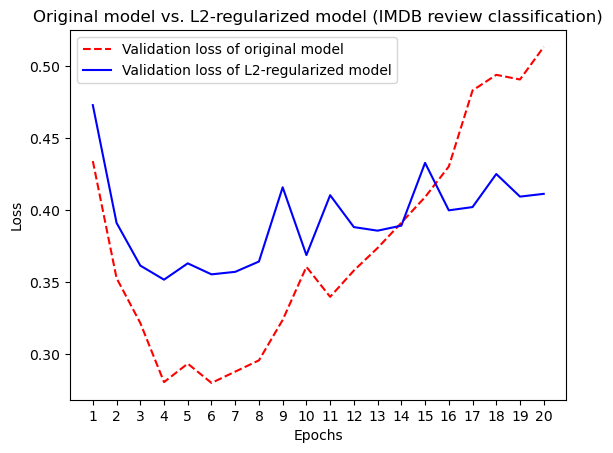

In [90]:
original_val_loss = history_original.history["val_loss"]
l2_val_loss = history_l2_reg.history["val_loss"]
epochs = range(1, 21)
plt.plot(
    epochs,
    original_val_loss,
    "r--",
    label="Validation loss of original model",
)
plt.plot(
    epochs,
    l2_val_loss,
    "b-",
    label="Validation loss of L2-regularized model",
)
plt.title(
    "Original model vs. L2-regularized model (IMDB review classification)"
)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()
plt.show()

L2 정규화 대신 다음과 같은 Keras 가중치 정규화기를 사용할 수 있습니다.

In [92]:
from keras import regularizers

# L1 regularization
regularizers.l1(0.001)
# Simultaneous L1 and L2 regularization
regularizers.l1_l2(l1=0.001, l2=0.001)

가중치 정규화는 일반적으로 소규모 딥러닝 모델에 더 많이 사용된다는 점에 유의하십시오. 대규모 딥러닝 모델은 매개변수가 과도하게 설정되어 있어 가중치 값에 제약을 두어도 모델의 성능과 일반화 능력에 큰 영향을 미치지 않는 경우가 많습니다. 이러한 경우에는 드롭아웃이라는 다른 정규화 기법이 더 적합합니다.

##### Adding dropout

드롭아웃은 토론토 대학교의 제프 힌튼 교수와 그의 학생들이 개발한 신경망에서 가장 효과적이고 널리 사용되는 정규화 기법 중 하나입니다. 드롭아웃은 학습 과정에서 해당 레이어의 출력 특징 중 일부를 무작위로 제거(0으로 설정)하는 방식입니다. 예를 들어, 특정 레이어가 학습 시 입력 샘플에 대해 [0.2, 0.5, 1.3, 0.8, 1.1]과 같은 벡터를 출력한다고 가정해 보겠습니다. 드롭아웃을 적용하면 이 벡터는 무작위로 분포된 몇 개의 0 값을 가지게 됩니다. 예를 들어, [0, 0.5, 1.3, 0, 1.1]과 같은 형태가 됩니다. 드롭아웃 비율은 0으로 설정되는 특징의 비율이며, 일반적으로 0.2에서 0.5 사이의 값으로 설정됩니다. 테스트 시에는 어떤 유닛도 제거되지 않습니다. 대신, 레이어의 출력 값은 드롭아웃 비율만큼 감소되어, 학습 시보다 더 많은 유닛이 활성화되어 있다는 점을 보정합니다.

레이어의 출력을 담고 있는 NumPy 행렬 `layer_output`을 생각해 봅시다. 이 행렬의 형태는 `(batch_size, features)`입니다. 학습 시에는 행렬 값 중 일부를 무작위로 0으로 만듭니다.

```
# At training time, drops out 50% of the units in the output
layer_output *= np.random.randint(low=0, high=2, size=layer_output.shape)
```

테스트 시에는 드롭아웃 비율만큼 출력을 축소합니다. 여기서는 0.5배로 스케일링합니다(이전에 절반의 유닛을 제거했기 때문입니다).

```
# At test time
layer_output *= 0.5
```
참고로, 이 과정은 학습 시 두 연산을 모두 수행하고 테스트 시에는 출력을 변경하지 않는 방식으로 구현할 수도 있으며, 실제로는 후자의 방식이 흔히 사용됩니다(그림 5.21 참조).

```
# At training time
layer_output *= np.random.randint(low=0, high=2, size=layer_output.shape)
# Note that we're scaling up rather scaling down in this case.
layer_output /= 0.5
```

<img src="https://deeplearningwithpython.io/images/ch05/dropout.8e0a70b8.png" width="500"><p style="text-align:center">Figure 5.21: Dropout applied to an activation matrix at training time, with rescaling happening during training. At test time, the activation matrix is unchanged.</p>


이 기법은 이상하고 임의적으로 보일 수 있습니다. 이것이 과적합을 줄이는 데 어떻게 도움이 될까요? 힌튼은 은행에서 사용하는 사기 방지 메커니즘에서 영감을 받았다고 말합니다.

>저는 제 은행에 갔습니다. 은행 창구 직원들이 계속 바뀌길래 한 직원에게 이유를 물어봤더니, 자기도 잘 모르겠지만 자주 이동한다고 하더군요. 아마 은행을 속이려면 직원들끼리 공모해야 하기 때문일 거라고 짐작했습니다. 이 경험을 통해 각 예제마다 무작위로 다른 뉴런 집합을 제거하면 음모론을 방지하고 과적합을 줄일 수 있다는 것을 깨달았습니다.

핵심 아이디어는 레이어 출력값에 노이즈를 도입하면 중요하지 않은 우연한 패턴(힌튼이 말하는 음모론)을 깨뜨릴 수 있다는 것입니다. 노이즈가 없으면 모델은 이러한 패턴을 암기하기 시작하죠.

케라스에서는 Dropout 레이어를 통해 모델에 드롭아웃을 적용할 수 있습니다. Dropout 레이어는 바로 앞 레이어의 출력에 적용됩니다. IMDB 모델에 Dropout 레이어를 두 개 추가해서 과적합을 얼마나 효과적으로 줄이는지 살펴보겠습니다.

In [95]:
model = keras.Sequential(
    [
        layers.Dense(16, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(16, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history_dropout = model.fit(
    train_data,
    train_labels,
    epochs=20,
    batch_size=512,
    validation_split=0.4,
)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5867 - loss: 0.6697 - val_accuracy: 0.6880 - val_loss: 0.5745
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7735 - loss: 0.5617 - val_accuracy: 0.7899 - val_loss: 0.5116
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8460 - loss: 0.5019 - val_accuracy: 0.8676 - val_loss: 0.4755
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8828 - loss: 0.4572 - val_accuracy: 0.8429 - val_loss: 0.4600
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9019 - loss: 0.4192 - val_accuracy: 0.8570 - val_loss: 0.4457
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9157 - loss: 0.3738 - val_accuracy: 0.8756 - val_loss: 0.4113
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9268 - loss: 0.3416 - val_accuracy: 0.8724 - val_loss: 0.4196
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9378 - loss: 0.3123 - val_accuracy: 0.8733 - v

그림 5.22는 결과 그래프를 보여줍니다. 이는 참조 모델에 비해 확연한 개선을 보여줍니다. 또한, 도달한 최저 검증 손실이 향상되었으므로 L2 정규화보다 훨씬 더 효과적인 것으로 보입니다.

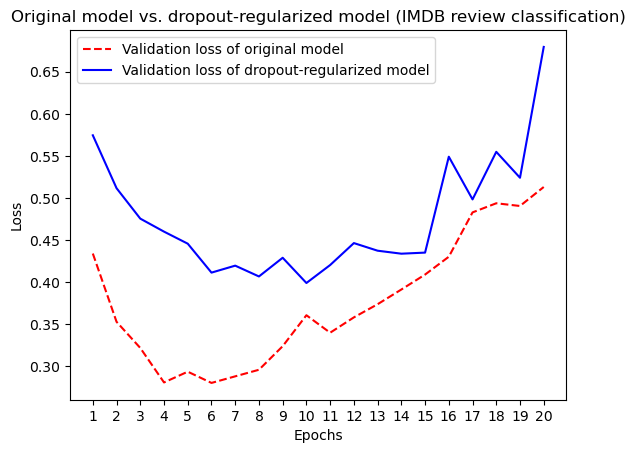

In [97]:
original_val_loss = history_original.history["val_loss"]
dropout_val_loss = history_dropout.history["val_loss"]
epochs = range(1, 21)
plt.plot(
    epochs,
    original_val_loss,
    "r--",
    label="Validation loss of original model",
)
plt.plot(
    epochs,
    dropout_val_loss,
    "b-",
    label="Validation loss of dropout-regularized model",
)
plt.title(
    "Original model vs. dropout-regularized model (IMDB review classification)"
)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()
plt.show()

요약하자면, 신경망에서 일반화 성능을 극대화하고 과적합을 방지하는 가장 일반적인 방법은 다음과 같습니다.

* 더 많은 훈련 데이터 또는 더 나은 훈련 데이터 확보
* 더 나은 특징 추출
* 모델 용량 줄이기
* 가중치 정규화 추가 (소형 모델의 경우)
* 드롭아웃 추가

### Summary

* 머신러닝 모델의 목적은 일반화, 즉 이전에 본 적 없는 입력에 대해서도 정확하게 작동하는 것입니다. 이는 생각보다 훨씬 어렵습니다.
* 심층 신경망은 훈련 샘플 간 보간을 성공적으로 수행할 수 있는 매개변수 모델을 학습함으로써 일반화를 달성합니다. 이러한 모델은 훈련 데이터의 잠재 매니폴드를 학습했다고 할 수 있습니다. 이것이 바로 딥러닝 모델이 훈련 중에 접했던 데이터와 매우 유사한 입력에 대해서만 의미를 부여할 수 있는 이유입니다.
* 머신러닝의 근본적인 문제는 최적화와 일반화 사이의 긴장 관계입니다. 일반화를 달성하려면 먼저 훈련 데이터에 잘 맞는 모델을 만들어야 하지만, 모델의 훈련 데이터 적합도를 개선하면 시간이 지남에 따라 일반화 성능이 저하될 수밖에 없습니다. 모든 딥러닝 모범 사례는 이러한 긴장 관계를 관리하는 것과 관련이 있습니다.
* 딥러닝 모델의 일반화 능력은 데이터의 잠재 매니폴드를 근사화하는 방법을 학습하고, 보간을 통해 새로운 입력에 대한 의미를 부여할 수 있다는 사실에서 비롯됩니다.

* 모델 개발 과정에서 모델의 일반화 능력을 정확하게 평가하는 것은 매우 중요합니다. 단순 홀드아웃 검증부터 K-겹 교차 검증, 셔플링을 사용한 반복 K-겹 교차 검증까지 다양한 평가 방법을 활용할 수 있습니다. 검증 데이터에서 모델로 정보가 유출될 수 있으므로 최종 모델 평가를 위해 완전히 분리된 테스트 세트를 항상 유지해야 합니다.
* 모델 개발을 시작할 때의 목표는 우선 어느 정도 일반화 능력을 갖추고 과적합될 수 있는 모델을 만드는 것입니다. 이를 위한 모범 사례로는 학습률과 배치 크기 조정, 더 나은 아키텍처 사전 정보 사용, 모델 용량 증가, 또는 단순히 더 긴 학습 시간 등이 있습니다.
* 모델이 과적합되기 시작하면, 모델은 정규화를 통해 일반화 능력을 향상시키는 방향으로 전환됩니다. 모델 용량을 줄이거나, 드롭아웃 또는 가중치 정규화를 추가하거나, 조기 종료를 사용할 수 있습니다. 그리고 당연히 더 크거나 더 나은 데이터셋을 사용하는 것이 모델의 일반화 능력을 향상시키는 가장 확실한 방법입니다.